BIRCH算法详解
https://zhuanlan.zhihu.com/p/29848130

In [19]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [20]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

### PCA

In [21]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA

def draw_pic(df, labels=None, filename='none'):
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df.values)
    if labels is None:
        plt.scatter(df_pca[:, 0], df_pca[:, 1], s=0.2)
    else:
        plt.scatter(df_pca[:, 0], df_pca[:, 1], s=0.2, c=1.0*labels)
    plt.savefig('./images/' + filename + '.png')

# Pre-processing

In [22]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

student_raw = pd.read_csv('./data/click_count.csv')
student_raw = student_raw.set_index('id_student')
student_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 6516 to 2698588
Data columns (total 20 columns):
dataplus          26074 non-null int64
dualpane          26074 non-null int64
externalquiz      26074 non-null int64
folder            26074 non-null int64
forumng           26074 non-null int64
glossary          26074 non-null int64
homepage          26074 non-null int64
htmlactivity      26074 non-null int64
oucollaborate     26074 non-null int64
oucontent         26074 non-null int64
ouelluminate      26074 non-null int64
ouwiki            26074 non-null int64
page              26074 non-null int64
questionnaire     26074 non-null int64
quiz              26074 non-null int64
repeatactivity    26074 non-null int64
resource          26074 non-null int64
sharedsubpage     26074 non-null int64
subpage           26074 non-null int64
url               26074 non-null int64
dtypes: int64(20)
memory usage: 4.2 MB


In [23]:
df = student_raw
student_8f = pd.DataFrame(index = df.index)
student_8f['motivational']=df['homepage'].apply(lambda x: float(x)/3)+df['externalquiz'].apply(lambda x: float(x)/3)+df['quiz'].apply(lambda x: float(x)/3)
student_8f['communicational']=df['forumng'].apply(lambda x: float(x)/2)+df['oucollaborate'].apply(lambda x: float(x)/2)
student_8f['visual']=df['url'].apply(lambda x: float(x)/2)+df['ouelluminate'].apply(lambda x: float(x)/2)
student_8f['verbal']=df['resource'].apply(lambda x: float(x)/2)+df['ouwiki'].apply(lambda x: float(x)/2)
student_8f['sensing']=df['dualpane']
student_8f['intuitive']=df['ouwiki']
student_8f['sequential']=df['subpage']
student_8f['global']=df['oucontent'].apply(lambda x: float(x)/3)+df['page'].apply(lambda x: float(x)/3)+df['repeatactivity'].apply(lambda x: float(x)/3)
student_8f.describe()

,motivational,communicational,visual,verbal,sensing,intuitive,sequential,global
count,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000
mean,120.927719,118.609784,8.964601,25.780068,0.595996,20.335468,96.263788,98.020672
std,179.289766,248.381887,15.799374,38.985257,2.361398,59.808478,130.461437,160.946917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,8.500000,0.500000,4.000000,0.000000,0.000000,14.000000,4.666667
50%,64.000000,44.500000,4.000000,12.500000,0.000000,0.000000,44.000000,31.333333
75%,144.666667,129.000000,11.500000,32.000000,0.000000,14.000000,131.000000,121.333333
max,4464.666667,4994.000000,935.000000,860.500000,68.000000,1708.000000,1603.000000,2272.666667


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

def array2df(array, df):
    df_copy = pd.DataFrame(data=array,
                         index = df.index,
                         columns = df.columns)
    return df_copy

df = student_8f
detecter = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
#outliers = detecter.fit_predict(df)
#draw_pic(df, outliers)
df['lof'] = detecter.fit_predict(df)
student_scaled = df[df['lof']>0]
print(len(student_scaled))
student_scaled = student_scaled.drop(columns=['lof'])
#student_scaled = student_8f

#总结：
#standardscaler+max：递减 77000
#standardscaler+l1：递减 9000
#standardscaler+l2：递减 7000

#MinMaxScaler+max:4最好 3442
#MinMaxScaler+l1:4最好 3800 形状不好看
#MinMaxScaler+l2:8最好 3900
scaler = MinMaxScaler()
scaler.fit(student_scaled)
student_scaled = array2df(scaler.transform(student_scaled), student_scaled)

student_scaled = array2df(normalize(student_scaled, norm='l2'), student_scaled)

25813


0.904965703884


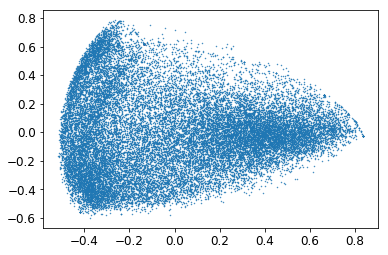

In [26]:
print(hopkins(student_scaled))
draw_pic(student_scaled, labels=None, filename='weighted_l2')

# Clustering

### Parameter tunning

In [8]:
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import Birch

def parameter_tunning(df, scoring_metric, branch_list,threshold_list,n_clusters_list):
    results = pd.DataFrame(columns=['branching_factor','threshold','n_subclusters','n_clusters','CH score'])
    record = pd.DataFrame(columns=['branching_factor','threshold','n_subclusters','n_clusters','CH score'], index=range(0,1))
    for factor in branch_list:
        record.iloc[0]['branching_factor'] = factor
        for x in threshold_list:
            record.iloc[0]['threshold'] = float(x)/100
            brc = Birch(branching_factor=factor, n_clusters=None, threshold=float(x)/100, compute_labels=True)
            brc.partial_fit(df)
            n_subclusters = max(brc.labels_)+1
            record.iloc[0]['n_subclusters'] = n_subclusters
            for k in n_clusters_list:
                if k>n_subclusters: break
                record.iloc[0]['n_clusters'] = k
                brc.set_params(n_clusters=k)
                brc.partial_fit()
                labels = brc.predict(df)
                record.iloc[0]['CH score'] = scoring_metric(df, labels)
                results = results.append(record, ignore_index=True)
    return results

### Stability

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import euclidean_distances
import math
from sklearn.cluster import Birch

np.random.seed(42)
def stability(cluster_algo, df, k=5, n=10):
    results = pd.DataFrame(-1, index = df.index, columns=list(map(lambda i: 'col'+str(i), range(1,n+1))))
    kfold = KFold(n_splits=n)
    i=1
    for train_indices, test_indices in kfold.split(df): #注意index是否一致
        train_set = df.iloc[train_indices]
        results.loc[train_set.index,'col'+str(i)] = cluster_algo.fit_predict(train_set)
        i+=1
    #计算
    indexs_I = []
    indexs_J = []
    overlap_score = []
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            indexs_I.clear()
            indexs_J.clear()
            overlap = 0.0
            for cluster in range(0,k):
                indexs_I.append(set(results.loc[results['col'+str(i)]==cluster].index))
                indexs_J.append(set(results.loc[results['col'+str(j)]==cluster].index))
            for index_set_I in indexs_I:
                max_overlap = 0.0
                for index_set_J in indexs_J:
                    if len(index_set_I | index_set_J) == 0: break
                    overlap_per = float(len(index_set_I & index_set_J))/len(index_set_I | index_set_J)
                    if overlap_per > max_overlap: max_overlap = overlap_per
                overlap += max_overlap
            overlap_score.append(overlap/k)
    return np.mean(overlap_score), np.std(overlap_score)

def parameter_tunning_stability(df,branch_list,threshold_list,n_clusters_list):
    results = pd.DataFrame(columns=['branching_factor','threshold','n_clusters','stability_mean','stability_std'])
    record = pd.DataFrame(columns=['branching_factor','threshold','n_clusters','stability_mean','stability_std'], index=range(0,1))
    for factor in branch_list:
        record.iloc[0]['branching_factor'] = factor
        for x in threshold_list:
            record.iloc[0]['threshold'] = float(x)/100
            for k in n_clusters_list:
                record.iloc[0]['n_clusters'] = k
                brc = Birch(branching_factor=factor, n_clusters=k, threshold=float(x)/100, compute_labels=True)
                record.iloc[0]['stability_mean'], record.iloc[0]['stability_std'] = stability(brc, df, k, n=10)
                results = results.append(record, ignore_index=True)
    return results

In [14]:
import time

print(time.strftime("%Y-%m-%d %X", time.localtime()))
branch_list=[300, 600]
threshold_list=range(10,60,10)
n_clusters_list=range(3,11,1)

df_ch = parameter_tunning(student_scaled,calinski_harabaz_score, branch_list,threshold_list,n_clusters_list)
df_ch.to_csv('./data/birch_performance_Click_Var_MAX_CH.csv', index=False)
print(time.strftime("%Y-%m-%d %X", time.localtime()))

df_stability = parameter_tunning_stability(student_scaled, branch_list,threshold_list,n_clusters_list)
df_stability.to_csv('./data/birch_performance_Click_Var_MAX_Stability.csv', index=False)
print(time.strftime("%Y-%m-%d %X", time.localtime()))

2017-12-25 21:10:26
2017-12-25 21:12:08
2017-12-25 21:36:20


### Birch

In [15]:
from sklearn.cluster import Birch

# threshold和n_clusters对聚类效果都有影响
brc = Birch(branching_factor=500, n_clusters=None, threshold=0.44, compute_labels=True)
brc.partial_fit(student_scaled)

def clustering_brich(df, k=5):
    brc.set_params(n_clusters=k)
    brc.partial_fit()
    return brc.predict(df)

print(max(brc.labels_)+1)

9


## Evaluation

Clustering... 3
Clustering... 4
Clustering... 5
Clustering... 6
Clustering... 7
Clustering... 8
Clustering... 9
Clustering... 10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: UserWarning: Number of subclusters found (9) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters))


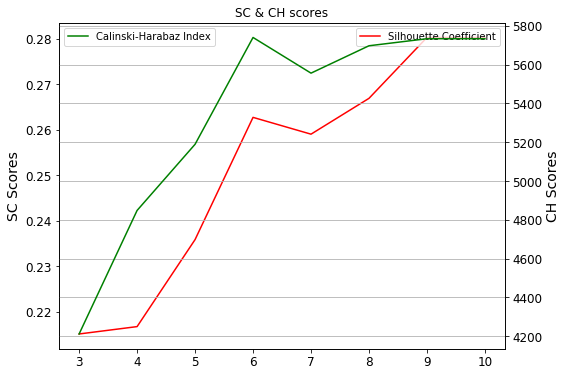

Max SC: 0.280263674914 , K = 6
Max CH: 5739.61980986 , K = 3


In [17]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

def drawEvaluationGraph(params, sc_scores, ch_scores, paramname):
    fig = plt.figure(figsize=(8,6))
    ax_sc = fig.add_subplot(111)
    ax_sc.plot(params, sc_scores, 'r', label="Silhouette Coefficient")
    ax_sc.legend(loc=1)
    ax_sc.set_ylabel('SC Scores')
    ax_ch = ax_sc.twinx()
    ax_ch.plot(params, ch_scores, 'g', label="Calinski-Harabaz Index")
    ax_ch.legend(loc=2)
    ax_ch.set_ylabel('CH Scores')
    ax_ch.set_xlabel(paramname);
    plt.title('SC & CH scores')
    plt.grid(params)
    plt.show()
    print('Max SC:', max(sc_scores), ', K =',sc_scores.index(max(sc_scores)))
    print('Max CH:', max(ch_scores), ', K =',ch_scores.index(max(ch_scores)))

labels_list = []
sc_score_list = []
ch_score_list = []
param_list = range(3, 11, 1)
for i in param_list:
    print('Clustering...', i)
    labels = clustering_brich(student_scaled, i)
    #print(max(labels)+1)
    labels_list.append(labels)
    sc_score_list.append(silhouette_score(student_scaled, labels, metric='euclidean'))
    #sc_score_list.append(0)
    ch_score_list.append(calinski_harabaz_score(student_scaled, labels))
drawEvaluationGraph(param_list, sc_score_list, ch_score_list, 'n_cluster')

In [18]:
print(sc_score_list)
print(ch_score_list)

[0.21510745810287499, 0.21672751275406069, 0.23584632504906611, 0.26270454549834854, 0.25901301215841122, 0.26688636816213029, 0.28026367491403315, 0.28026367491403315]
[4211.5828583167304, 4848.2012555835172, 5189.1434204030647, 5739.6198098612649, 5555.7755197504348, 5696.8627574465263, 5733.1647753110528, 5733.1647753110537]


In [ ]:
# threshold和n_clusters对聚类效果都有影响
brc = Birch(branching_factor=500, n_clusters=6, threshold=0.44, compute_labels=True)
student_labels = brc.partial_predict(student_scaled)

def clustering_brich(df, k=5):
    brc.set_params(n_clusters=k)
    brc.partial_fit()
    return brc.predict(df)

## Visualization

SC: 0.262704545498
CH: 5739.61980986
6


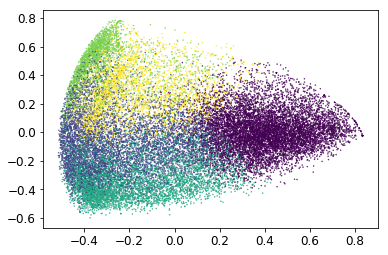

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.cluster import Birch

brc = Birch(branching_factor=500, n_clusters=6, threshold=0.44, compute_labels=True)
student_labels = brc.fit_predict(student_scaled)
print('SC:', silhouette_score(student_scaled, student_labels, metric='euclidean'))
print('CH:', calinski_harabaz_score(student_scaled, student_labels))
print(max(student_labels)+1)
draw_pic(student_scaled, student_labels, 'weighted_l2_birch6')

### Generate final clusters

In [30]:
student_scaled['cluster'] = student_labels
student_scaled.to_csv('./data/clustering_weighted_l2_birch6.csv')